# RSM338 Assignment 2: clustering by Investment Risk

This report develops a data-driven framework for categorizing countries by investment risk using clustering algorithms. I will be analyzing 122 countries across four risk indicators — Corruption, Peace, Legal, and GDP Growth — to discover natural groupings based on objective measures rather than subjective or pre-defined categories (e.g., "developed" vs. "emerging"). The primary data source is the country risk dataset adapted from *Machine Learning in Business* (Hull et al., 2025), containing indicators from Transparency International, the Institute for Economics and Peace, the Property Rights Association, and the IMF.

## Data Preparation

**(i)** Load the country risk data into a pandas DataFrame, inspect the first few rows, and check for missing values.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('Country Risk Data Assignment 2.csv')

# Inspect the first few rows
df.head()

,Country,Abbrev,Corruption,Peace,Legal,GDP Growth
0,Albania,AL,39,1.867,3.822,5.000
1,Algeria,DZ,34,2.213,4.160,4.202
2,Argentina,AR,36,1.957,4.568,-2.298
3,Armenia,AM,33,2.218,4.126,0.208
4,Australia,AU,79,1.465,8.244,2.471


### Examining Feature Scales

I'll compute summary statistics for each feature i.e. the minimum, maximum, range, mean, and standard deviation. This is important because clustering algorithms like K-Means use distance calculations, and features with larger ranges will dominate unless the data is standardized.

In [15]:
# Summary statistics for the four features
features = ['Corruption', 'Peace', 'Legal', 'GDP Growth']
summary = df[features].describe().T
summary['range'] = summary['max'] - summary['min']
summary[['min', 'max', 'range', 'mean', 'std']]

,min,max,range,mean,std
Corruption,14.000,90.000,76.000,46.237705,19.126397
Peace,1.192,3.399,2.207,2.003730,0.447826
Legal,2.728,8.633,5.905,5.598861,1.487328
GDP Growth,-18.000,7.958,25.958,2.385656,3.248836


**Interpretation:**

The four features operate on very different scales:

- **Corruption** has the **largest range** at 76 points (14 to 90), on a 0–100 scale.
- **GDP Growth** also has a wide range of approximately 26 percentage points (−18% to +8%), driven by outliers such as Venezuela (−18%) and Ethiopia (+7.96%).
- **Legal** spans about 5.9 points (2.73 to 8.63) on a 0–10 scale.
- **Peace** has the **smallest range** at roughly 2.2 points (1.19 to 3.40) on a 1–5 scale.

These scale differences confirm that **standardization will be essential** before applying any distance-based clustering algorithm. Without standardization, Corruption (range 76) would dominate the Euclidean distance calculations, effectively making the other three features negligible in determining cluster assignments.

In [16]:
# Extract the four numeric features into a feature matrix
X = df[features]

# Standardize features to have mean=0 and std=1 then convert back to DataFrame
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Corruption,-1.783637e-16,1.004124,-1.692459,2.297493
Peace,-3.922181e-16,1.004124,-1.820077,3.128505
Legal,-1.838238e-16,1.004124,-1.938173,2.048406
GDP Growth,-1.046522e-16,1.004124,-6.300633,1.722255


**Interpretation:**

After standardization, all four features now have a **mean of approximately 0** and a **standard deviation of 1**. 


## Problem 1: Exploratory Data Analysis

### Task (a): Scatter Plot Matrix

I'll create a scatter plot matrix to visualize the pairwise relationships between all four features. This will help identify correlations, potential clusters, and outliers before applying any clustering algorithms. I'll use `pandas.plotting.scatter_matrix()` on the raw (unstandardized) features so the axis labels remain interpretable.

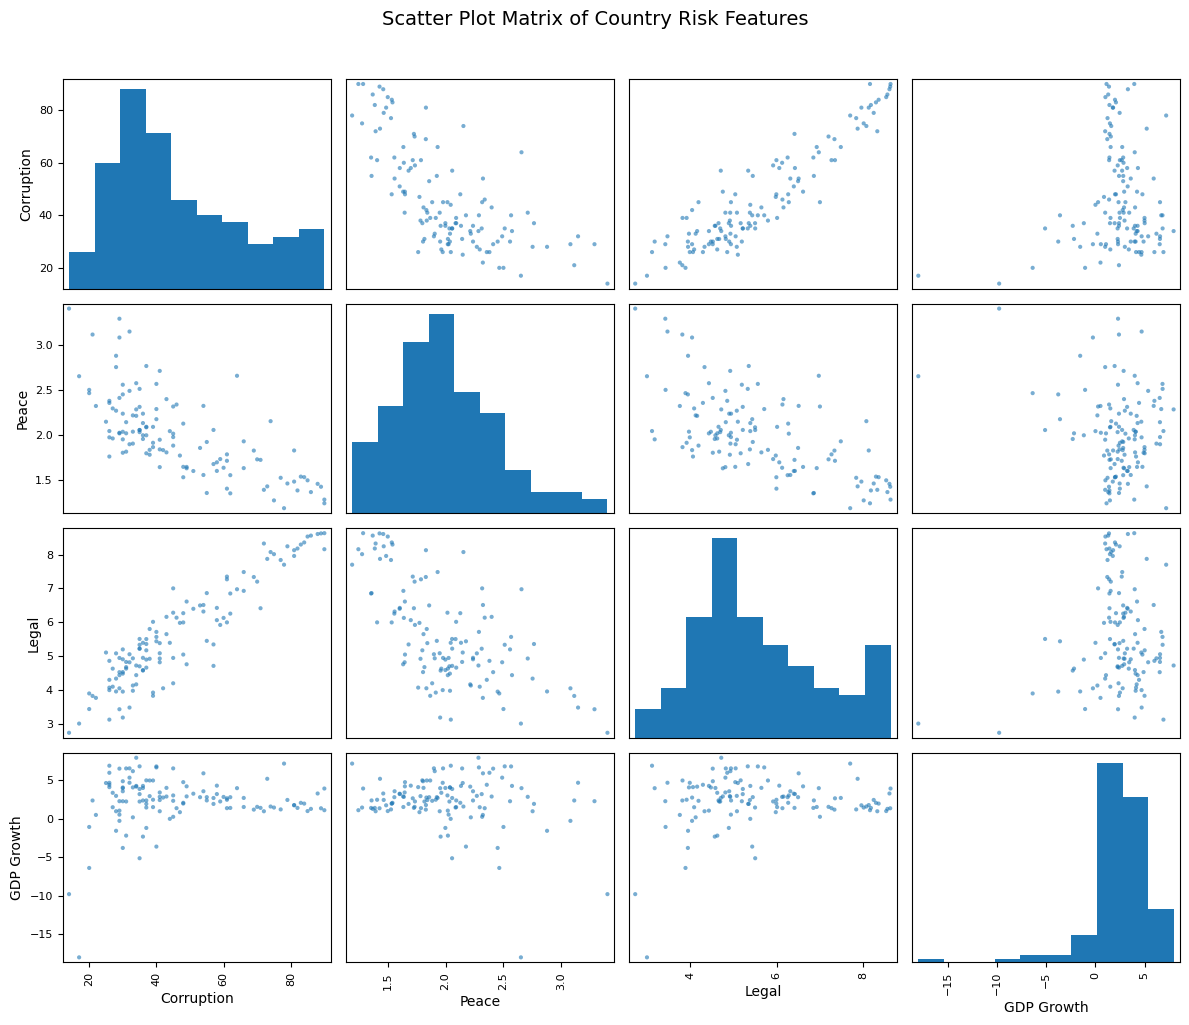

       Country Abbrev  Corruption  Peace  Legal  GDP Growth
0      Albania     AL          39  1.867  3.822       5.000
1      Algeria     DZ          34  2.213  4.160       4.202
2    Argentina     AR          36  1.957  4.568      -2.298
3      Armenia     AM          33  2.218  4.126       0.208
4    Australia     AU          79  1.465  8.244       2.471
..         ...    ...         ...    ...    ...         ...
117  Venezuela     VE          17  2.651  3.000     -18.000
118    Vietnam     VI          33  1.906  4.930       6.211
119      Yemen     YE          14  3.399  2.728      -9.779
120     Zambia     ZM          38  1.783  4.917       2.967
121   Zimbabwe     ZW          22  2.322  3.760       0.522

[122 rows x 6 columns]


In [17]:
# Scatter plot matrix of the four risk features
from pandas.plotting import scatter_matrix

axes = scatter_matrix(df[features], figsize=(12, 10), alpha=0.6,
                      diagonal='hist', grid=True)

plt.suptitle('Scatter Plot Matrix of Country Risk Features', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()
print(df)

**Interpretation:**

**Correlated pairs:** The scatter plot matrix reveals a **strong positive correlation between Corruption and Legal** — countries with cleaner governance tend to have stronger property rights protections, which makes intuitive sense as both reflect institutional quality. There is also a **negative correlation between Corruption and Peace** (and similarly between Legal and Peace), meaning countries with higher corruption scores (i.e., less corrupt) tend to be more peaceful (lower Peace index values). GDP Growth shows **no clear linear relationship** with the other three features.

**Visible clusters:** The Corruption vs. Legal scatter plot shows what appears to be **two or three natural groupings**: a tight cluster of high-Corruption, high-Legal countries in the upper right (developed nations), a dense mass of low-Corruption, low-Legal countries in the lower left (higher-risk countries), and a spread of countries in between. Similar groupings are faintly visible in the Corruption vs. Peace plot.

**Outliers:** A few countries stand out prominently. In the GDP Growth dimension, **Venezuela** (approximately −18%) and **Yemen** (approximately −10%) are extreme negative outliers, sitting far below the bulk of the distribution. **Chad** also appears as an outlier with very negative growth. These countries experienced severe economic contractions during the data period. On the Peace axis, **Pakistan, Ukraine, and Yemen** (Peace > 3.0) stand out as notably less peaceful than the rest of the sample.

### Task (b): Correlation Matrix

I'll compute the correlation matrix for the four features to quantify the linear relationships observed in the scatter plot matrix. This will confirm which pair has the strongest correlation and whether the visual patterns hold up numerically.

In [18]:
# Compute and display the correlation matrix for the four features
corr_matrix = df[features].corr()
# Rounds to 3 decimal places for readability
corr_matrix.round(3)

,Corruption,Peace,Legal,GDP Growth
Corruption,1.000,-0.700,0.924,0.101
Peace,-0.700,1.000,-0.652,-0.201
Legal,0.924,-0.652,1.000,0.118
GDP Growth,0.101,-0.201,0.118,1.000


**Interpretation:**

The **strongest correlation** is between **Corruption and Legal** at **r = 0.924**, a very strong positive relationship. This makes strong intuitive sense from a country risk perspective: both indicators measure aspects of **institutional quality**. Countries with low corruption (i.e., high Corruption Perceptions Index scores) tend to have robust legal systems that protect property rights, and vice versa. These institutions reinforce each other — strong rule of law deters corrupt behavior, and clean governance supports the legal framework.

Other notable correlations:
- **Corruption and Peace** (r = −0.700): moderately strong negative correlation. Less corrupt countries tend to be more peaceful (recall that *lower* Peace index values indicate *greater* peacefulness).
- **Legal and Peace** (r = −0.652): similarly, stronger property rights are associated with more peaceful countries.
- **GDP Growth** shows only **weak correlations** with all other features (|r| < 0.21), suggesting that short-term economic growth is largely independent of a country's institutional quality and security conditions. This means GDP Growth will provide distinct information for clustering that the other three features do not capture.

### Task (c): Why Standardize Before Clustering?

K-Means clustering assigns observations to clusters by minimizing Euclidean distance to cluster centroids. The Euclidean distance between two observations across $p$ features is:

$$d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{j=1}^{p}(x_j - y_j)^2}$$

Each feature's contribution to this distance is proportional to its **scale**. As I showed in the summary statistics table above, the four features have vastly different ranges: Corruption spans 76 points, GDP Growth spans ~26 percentage points, Legal spans ~5.9 points, and Peace spans only ~2.2 points. If I ran K-Means on the raw unstandardized data, **Corruption would completely dominate** the distance calculations because a difference of, say, 10 units in Corruption contributes $10^2 = 100$ to the squared distance, whereas a comparable relative difference in Peace (e.g., 0.3 units) contributes only $0.3^2 = 0.09$. The clustering would effectively be based almost entirely on Corruption alone, with the other three features having negligible influence on cluster assignments.

This is why I applied `StandardScaler` in the Data Preparation section — by transforming each feature to have mean 0 and standard deviation 1, a one-unit difference in any standardized feature now represents "one standard deviation" regardless of the original scale. This ensures all four risk indicators contribute equally to the distance calculations, producing clusters that genuinely reflect a country's overall risk profile rather than just its corruption score.

## Problem 2: K-Means Clustering

I'll now apply K-Means clustering to group the 122 countries by their risk profiles. The feature matrix `X` and standardized features `X_scaled` were already prepared in the Data Preparation section above using `StandardScaler`. All clustering in this section will use the standardized features to ensure equal contribution from each risk indicator.

In [19]:
# insert the previou code for report
X = df[features]

# Standardize features to have mean=0 and std=1 then convert back to DataFrame
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Corruption,-1.783637e-16,1.004124,-1.692459,2.297493
Peace,-3.922181e-16,1.004124,-1.820077,3.128505
Legal,-1.838238e-16,1.004124,-1.938173,2.048406
GDP Growth,-1.046522e-16,1.004124,-6.300633,1.722255


### Task (a): The Elbow Method
I'll run K-Means for $K = 1, 2, \ldots, 10$ and record the WCSS for each. As $K$ increases, WCSS necessarily decreases (more clusters = tighter fit), but at some point adding more clusters yields diminishing returns. The "elbow" in the plot — where the rate of decrease sharply levels off — suggests a good trade-off between model complexity and fit.

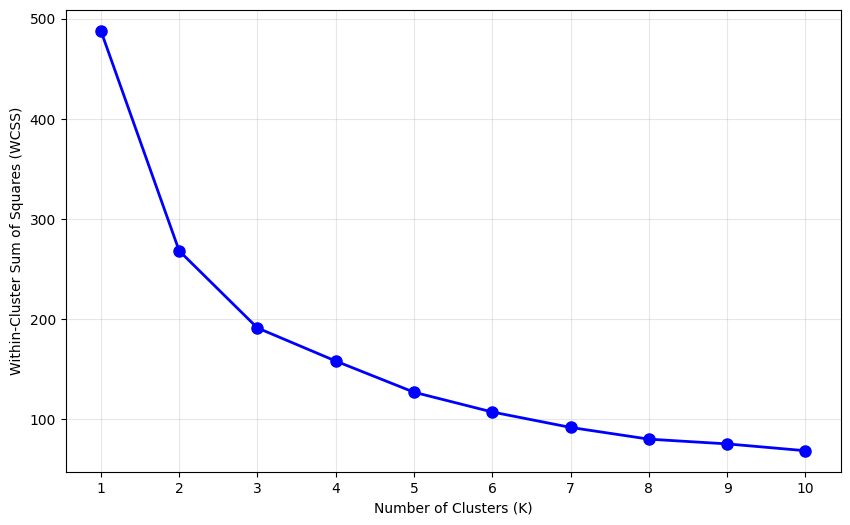

In [20]:
from sklearn.cluster import KMeans

# Run K-Means for K=1 to K=10 and record WCSS
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.show()

**Interpretation:**

The elbow plot shows a sharp decrease in WCSS from $K=1$ to $K=3$, after which the rate of improvement begins to flatten. Elbow occurs at **$K=3$**, where the curve transitions from steep decline to a more gradual slope. While there is a secondary bend around $K=4$ or $K=5$, the marginal reduction in WCSS beyond $K=3$ is relatively modest — each additional cluster provides diminishing returns in terms of explained variance, So I would recommend **$K=3$ clusters** based on this analysis. Three clusters strikes a good balance between capturing meaningful structure in the data and maintaining interpretability — too few clusters would lump very different countries together, while too many would create groups that are difficult to distinguish or interpret from an investment risk perspective.

### Task (b): Fitting K-Means with K=3 and Interpreting Centroids

I'll fit a K-Means model with $K=3$ clusters to the standardized data and mark the centroids in standardized units. Each centroid represents the "average country" in that cluster, positive values indicate the cluster is above the global mean for that feature and negative values indicate below.

In [21]:
# Fit K-Means with K=3 on the standardized data
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(X_scaled)

# Store cluster assignments in the original DataFrame
df['Cluster'] = kmeans_3.labels_

# Display the cluster centers (centroids) in standardized units
centroids = pd.DataFrame(kmeans_3.cluster_centers_, columns=features,
                         index=[f'Cluster {i}' for i in range(3)])
centroids.round(3)

,Corruption,Peace,Legal,GDP Growth
Cluster 0,-0.480,0.263,-0.435,0.376
Cluster 1,1.231,-0.979,1.166,0.006
Cluster 2,-1.027,1.352,-1.059,-1.720


**Interpreting the Centroids**

Higher **Corruption (CPI)** = less corrupt, higher **Peace (GPI)** = *less* peaceful, higher **Legal** = stronger rule of law, higher **GDP Growth** = faster economic expansion.

- **Cluster 1 (Low Risk):** Countries with the *least* corruption (CPI well above average), the *most* peaceful environments (low GPI), and the *strongest* legal frameworks. GDP growth is near the global mean, consistent with mature, developed economies that grow slowly but steadily.

- **Cluster 0 (Moderate Risk):** The largest "middle" group — slightly below-average governance and legal institutions, but with the *highest* GDP growth among the three clusters. These are likely emerging/developing economies where institutions are still maturing but economic momentum is strong.

- **Cluster 2 (High Risk):** Countries with the *most* corruption, the *least* peaceful conditions, the *weakest* legal systems, and sharply *negative* GDP growth. This cluster captures fragile or conflict-affected states where investment risk is highest.

### Task (c): Country Membership by Cluster

I'll list the countries assigned to each cluster and evaluate whether the groupings make intuitive sense from a country risk and investment perspective.

In [22]:
# Display the countries in each cluster, sorted alphabetically
for c in sorted(df['Cluster'].unique()):
    cluster_countries = df[df['Cluster'] == c]['Country'].sort_values().tolist()
    print(f"Cluster {c} ({len(cluster_countries)} countries):")
    # Print countries in a readable comma-separated format
    print(', '.join(cluster_countries))
    print()

Cluster 0 (68 countries):
Albania, Algeria, Armenia, Bahrain, Bangladesh, Benin, Bolivia, Bosnia and Herzegovina, Bulgaria, Cameroon, China, Colombia, Croatia, Cyprus, Dominican Republic, Egypt, El Salvador, Ethiopia, Gabon, Georgia, Ghana, Greece, Guatemala, Honduras, India, Indonesia, Iran, Israel, Italy, Jamaica, Jordan, Kazakhstan, Kenya, Kuwait, Liberia, Madagascar, Malawi, Mali, Mauritania, Mexico, Moldova, Montenegro, Morocco, Mozambique, Nepal, Nicaragua, Oman, Pakistan, Panama, Paraguay, Peru, Philippines, Romania, Rwanda, Saudi Arabia, Senegal, Serbia, Sierra Leone, South Africa, Sri Lanka, Tanzania, Thailand, The FYR of Macedonia, Tunisia, Turkey, Uganda, Vietnam, Zambia

Cluster 1 (39 countries):
Australia, Austria, Belgium, Botswana, Canada, Chile, Costa Rica, Czech Republic, Denmark, Estonia, Finland, France, Germany, Hungary, Iceland, Ireland, Japan, Korea (South), Latvia, Lithuania, Malaysia, Mauritius, Netherlands, New Zealand, Norway, Poland, Portugal, Qatar, Singapor

**Interpretation:**

The groupings align well with real-world perceptions of country risk and development:

**Cluster 1 — Low Risk (39 countries):**
- **Canada** (Corruption: 82, Peace: 1.39, Legal: 8.18): A natural fit — Canada consistently ranks among the world's least corrupt, most peaceful, and strongest rule-of-law countries, making it a textbook low-risk investment destination.
- **Singapore** (Corruption: 84, Peace: 1.54, Legal: 8.36): One of Asia's premier financial hubs with world-class governance and legal infrastructure, its placement here reflects its reputation as a safe, well-regulated market.
- **Botswana** (Corruption: 60, Peace: 1.64, Legal: 6.13): Perhaps the most interesting inclusion — Botswana is often cited as Africa's governance success story, with strong institutions relative to its regional peers. 

**Cluster 0 — Moderate Risk (68 countries):**
- **India** (Corruption: 40, Peace: 2.57, Legal: 5.56, GDP Growth: 6.83%): India's moderate institutional scores paired with high growth make it a textbook emerging market — significant opportunity but with governance and security risks.
- **China** (Corruption: 40, Peace: 2.29, Legal: 5.71, GDP Growth: 6.70%): Similar to India, China's rapid growth coexists with middling governance scores, placing it squarely in the moderate-risk category despite being the world's second-largest economy.
- **Italy** (Corruption: 47, Peace: 1.77, Legal: 5.98, GDP Growth: 0.88%): A somewhat surprising placement alongside emerging markets, but Italy's corruption challenges and slower growth relative to Northern European peers explain why the algorithm groups it here rather than with the low-risk cluster.

**Cluster 2 — High Risk (15 countries):**
- **Venezuela** (Corruption: 17, Peace: 2.65, Legal: 3.00, GDP Growth: −18.0%): The most extreme case in the dataset — a country in deep economic and institutional collapse, with the worst GDP contraction by far. Its placement as the highest-risk country is unambiguous.
- **Yemen** (Corruption: 14, Peace: 3.40, Legal: 2.73, GDP Growth: −9.78%): Ongoing conflict has devastated Yemen's economy and institutions, giving it the worst scores on Corruption, Peace, and Legal in the entire dataset.
- **Ukraine** (Corruption: 29, Peace: 3.29, Legal: 3.42, GDP Growth: 2.31%): Despite positive GDP growth, Ukraine's extremely high Peace index (reflecting armed conflict) and weak institutional scores place it in the high-risk cluster — a reminder that growth alone does not make a country safe for investment.

Overall, the K-Means algorithm has produced **intuitively sensible groupings** that broadly correspond to the traditional developed/emerging/fragile-state spectrum, but with the advantage of being derived entirely from objective data rather than subjective analysis.

### Task (d): The Silhouette Score

I'll compute the silhouette score for $K = 2, 3, \ldots, 10$ clusters and plot the results. The silhouette score measures how well each observation fits within its assigned cluster compared to the nearest neighboring cluster. It ranges from −1 to +1, where higher values indicate better-defined, more separated clusters. Unlike WCSS (which always decreases with more clusters), the silhouette score can identify the K that produces the most distinct groupings.

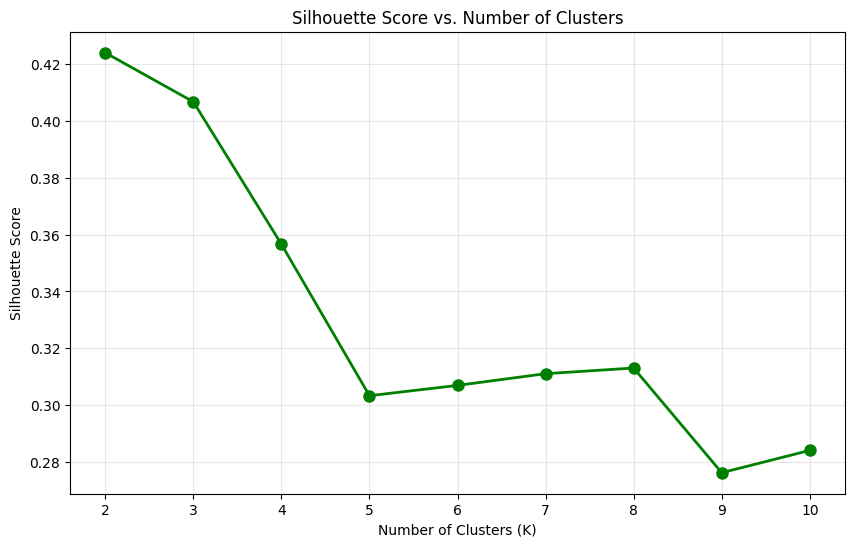

K=2: Silhouette Score = 0.4240
K=3: Silhouette Score = 0.4068
K=4: Silhouette Score = 0.3566
K=5: Silhouette Score = 0.3033
K=6: Silhouette Score = 0.3069
K=7: Silhouette Score = 0.3110
K=8: Silhouette Score = 0.3130
K=9: Silhouette Score = 0.2762
K=10: Silhouette Score = 0.2840


In [23]:
from sklearn.metrics import silhouette_score

# Compute silhouette scores for K=2 to K=10
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, sil_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xticks(range(2, 11))
plt.grid(True, alpha=0.3)
plt.show()

# Print the scores for reference
for k, s in zip(K_range, sil_scores):
    print(f'K={k}: Silhouette Score = {s:.4f}')

**Interpretation:**

The silhouette plot shows that **$K=2$ achieves the highest silhouette score**, indicating the most well-separated clustering. This makes intuitive sense — the dendrogram in Problem 3(a) also showed that the largest gap occurs before the final merge, supporting a 2-cluster split as the most natural partition.

However, the silhouette score for **$K=3$ is the second-highest**, and the drop from $K=2$ to $K=3$ is modest. Beyond $K=3$, the scores decline more noticeably, confirming that adding a fourth or fifth cluster does not improve cluster separation. The two methods give slightly different answers: the elbow method pointed to $K=3$, while the silhouette score favors $K=2$. This is not uncommon — the elbow method measures within-cluster compactness, while the silhouette score measures both compactness *and* separation between clusters. They optimize different objectives and can differ.

I would trust the **elbow method’s recommendation of $K=3$** for this analysis. While $K=2$ produces slightly better-separated clusters, it lumps the moderate-risk emerging economies and the high-risk fragile states into a single group. The 3-cluster solution sacrifices a small amount of statistical separation in exchange for a much more meaningful grouping. 

## Problem 3: Hierarchical Clustering

I'll now apply hierarchical clustering to the same standardized data. Unlike K-Means, hierarchical clustering does not require specifying $K$ in advance — instead, it builds a tree that lets me visually inspect the cluster structure before choosing how many groups to keep.

### Task (a): Dendrogram with Ward's Linkage

I'll perform hierarchical clustering using **Ward's linkage**, which merges the pair of clusters that causes the smallest increase in total within-cluster variance at each step. This is analogous to K-Means' WCSS objective and tends to produce compact, similarly-sized clusters. I'll then plot the full dendrogram to visualize the merge.

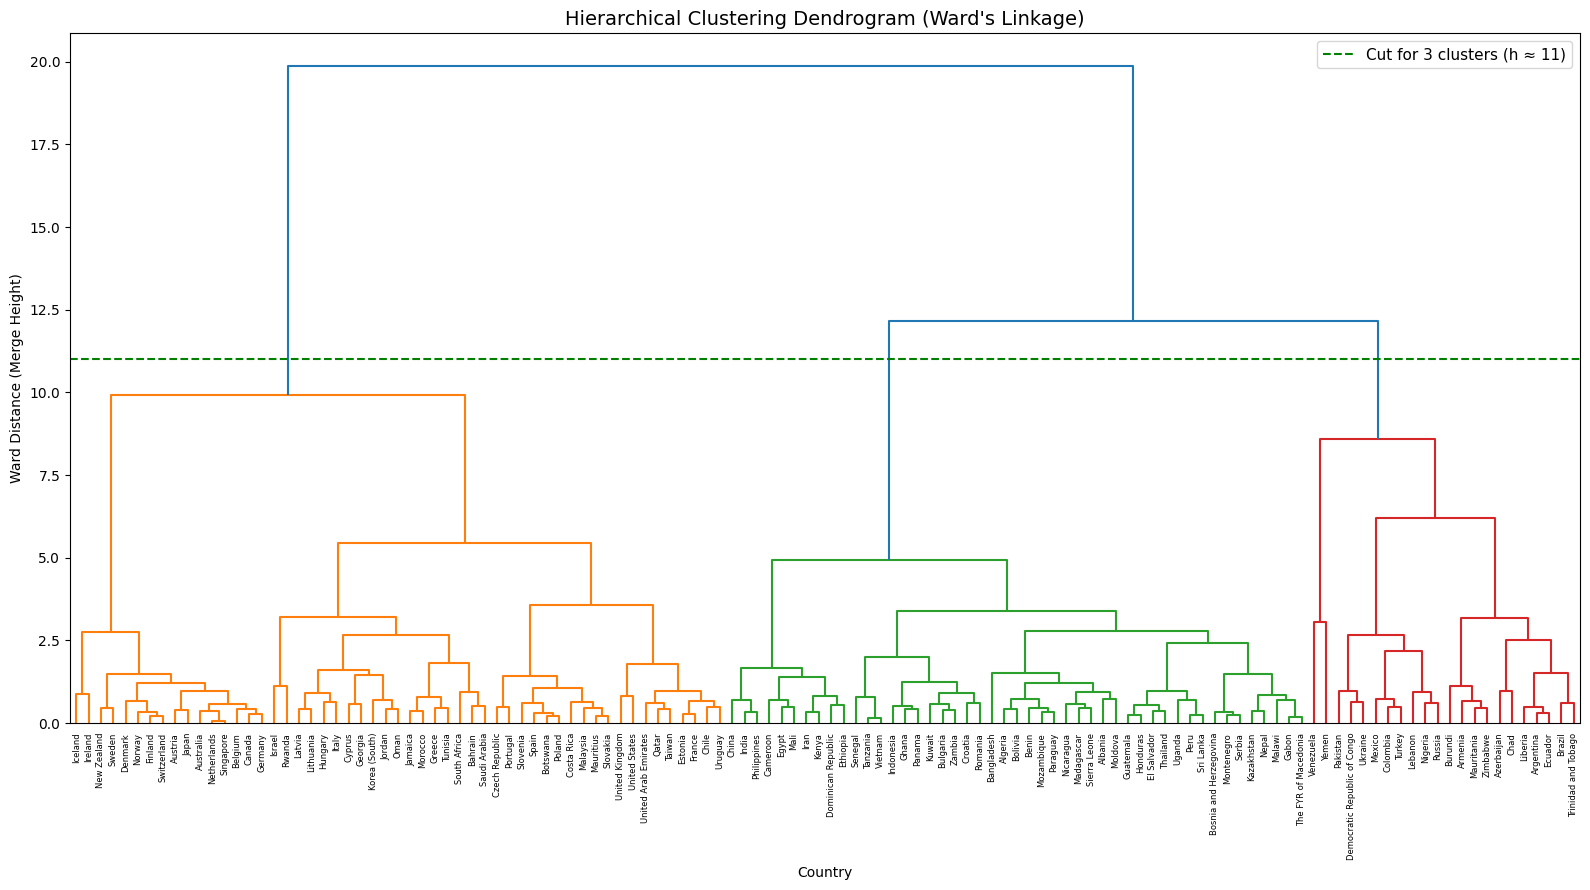

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform agglomerative clustering with Ward's linkage on standardized data
merge_height = linkage(X_scaled, method='ward')

# Plot the full dendrogram
plt.figure(figsize=(16, 9))
dendrogram(merge_height, labels=df['Country'].values, leaf_rotation=90, leaf_font_size=6,
           color_threshold=11)

# Add a horizontal line at the cut height for K=3
plt.axhline(y=11, color='green', linestyle='--', linewidth=1.5, label='Cut for 3 clusters (h \u2248 11)')
plt.title('Hierarchical Clustering Dendrogram (Ward\'s Linkage)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Ward Distance (Merge Height)')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

**Interpretation:**

To obtain the same $K=3$ clusters as my K-Means solution, I would cut the dendrogram at approximately **11** (the green dashed line). This falls between the third-to-last merge h = 9.9 and the second-to-last merge h = 12.2, producing exactly three branches.

The dendrogram reveals two big gaps:

1. **The largest gap** occurs between the second-to-last merge h = 12.2 and the final merge h = 19.9 a jump of roughly 7.7 units. This is the biggest distance increase in the entire tree, suggesting that the final merge combines two very dissimilar groups. This gap supports **$K=2$** as a natural partition.
2. **The second notable gap** appears between approximately h = 9.9 and h = 12.2, a jump of about 2.3 units. Cutting just below this merge yields **$K=3$** clusters, consistent with the elbow method recommendation.

### Task (b): Comparing Hierarchical and K-Means Cluster Assignments

I'll cut the dendrogram at 3 clusters using `fcluster` and compare the resulting assignments to the K-Means labels from Problem 2. To identify which hierarchical cluster corresponds to which K-Means cluster, I'll compute the centroids of each hierarchical cluster and match them by their risk profiles. Then I'll visualize both solutions side by side and identify any countries that are assigned differently.

In [25]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at 3 clusters
df['Hier_Cluster'] = fcluster(merge_height, t=3, criterion='maxclust')

# Compute hierarchical cluster centroids to identify each group's risk profile
hier_centroids = X_scaled.groupby(df['Hier_Cluster'])[features].mean()
hier_centroids.index.name = 'Hier Cluster'
print(hier_centroids.round(3))
print(centroids.round(3))

              Corruption  Peace  Legal  GDP Growth
Hier Cluster                                      
1                  0.924 -0.634  0.922      -0.014
2                 -0.617  0.109 -0.600       0.593
3                 -0.907  1.295 -0.941      -1.233
           Corruption  Peace  Legal  GDP Growth
Cluster 0      -0.480  0.263 -0.435       0.376
Cluster 1       1.231 -0.979  1.166       0.006
Cluster 2      -1.027  1.352 -1.059      -1.720


**Matching clusters by profile:** Comparing the centroids above, I can identify the correspondence:
- **Hier Cluster 1** (high Corruption, low Peace, high Legal) matches **K-Means Cluster 1** (Low Risk)
- **Hier Cluster 2** (moderate scores across all features) matches **K-Means Cluster 0** (Moderate Risk)
- **Hier Cluster 3** (low Corruption, high Peace, low Legal, negative GDP Growth) matches **K-Means Cluster 2** (High Risk)


In [26]:
# Create aligned labels based on the correspondence identified above
# Hier 1 → KMeans 1 (Low Risk)
# Hier 2 → KMeans 0 (Moderate Risk)  
# Hier 3 → KMeans 2 (High Risk)
mapping = {1: 1, 2: 0, 3: 2}
df['Hier_Aligned'] = df['Hier_Cluster'].map(mapping)

In [27]:
# Count how many countries are assigned to the same cluster by both methods
same_cluster = (df['Cluster'] == df['Hier_Aligned']).sum()
diff_cluster = len(df) - same_cluster
print(f'Countries in the SAME cluster by both methods: {same_cluster} / {len(df)}')
print(f'Countries in DIFFERENT clusters: {diff_cluster}\n')

# Show the countries that differ
diff = df[df['Cluster'] != df['Hier_Aligned']][['Country', 'Cluster', 'Hier_Aligned'] + features]
diff.columns = ['Country', 'KMeans', 'Hierarchical'] + features
print(diff.to_string(index=False))

Countries in the SAME cluster by both methods: 101 / 122
Countries in DIFFERENT clusters: 21

     Country  KMeans  Hierarchical  Corruption  Peace  Legal  GDP Growth
     Armenia       0             2          33  2.218  4.126       0.208
     Bahrain       0             1          43  2.398  6.157       2.915
    Colombia       0             2          37  2.764  5.354       1.960
      Cyprus       0             1          55  1.924  5.447       2.836
     Georgia       0             1          57  2.057  4.707       2.723
      Greece       0             1          44  2.044  5.389       0.012
      Israel       0             1          64  2.656  6.974       4.003
       Italy       0             1          47  1.774  5.979       0.880
     Jamaica       0             1          39  2.091  6.010       1.540
      Jordan       0             1          48  2.127  6.266       2.100
     Liberia       0             2          37  1.998  4.893      -1.170
  Mauritania       0          

**Interpretation:**

**101 out of 122 countries** (83%) are assigned to the same cluster by both methods. The **21 countries that differ** are all cases where K-Means placed them in Cluster 0 (moderate risk), but hierarchical clustering moved them either up to Cluster 1 (low risk) or down to Cluster 2 (high risk). This makes sense — the moderate-risk cluster is the largest and most heterogeneous group, so countries near its boundaries are the most susceptible to shifting when the algorithm changes.

**Borderline cases moved to Low Risk (Cluster 1):**
- **Italy** (Corruption: 47, Legal: 5.98): K-Means placed Italy in the moderate-risk cluster due to its below-average corruption score relative to Northern European peers. Hierarchical clustering groups it with developed economies based on its overall institutional profile — a reasonable alternative reading.
- **Israel** (Corruption: 64, Legal: 6.97): Strong institutional scores near the low-risk threshold, but an elevated Peace index (2.66, reflecting regional conflict) pulls it toward moderate risk under K-Means.
- **Greece** (Corruption: 44, Legal: 5.39): A developed economy with weaker-than-average governance among its OECD peers, sitting right on the boundary.

**Borderline cases moved to High Risk (Cluster 2):**
- **Pakistan** (Peace: 3.15, GDP Growth: 4.71%): Despite positive growth, Pakistan's very high Peace index (among the worst in the dataset) places it on the boundary. Hierarchical clustering groups it with high-risk countries based on its conflict profile.
- **Colombia** (Peace: 2.76, Corruption: 37): Elevated conflict levels and weak governance place it on the edge between moderate and high risk.
- **Mexico** (Peace: 2.56, Corruption: 30): Security concerns and corruption push it toward the high-risk boundary.

These borderline countries highlight that **cluster boundaries are not sharp dividing lines** but rather gradual transitions. Countries near cluster edges may reasonably be grouped either way, which is why using multiple clustering methods provides a more robust assessment than relying on any single algorithm.

### Task (c): K-Means vs. Hierarchical Clustering — Tradeoffs

**K-Means** requires specifying K upfront, which means you need some prior idea of how many clusters to expect (from the elbow method, silhouette analysis, or domain knowledge). It is fast and scales well to large datasets, but relies on random initialization — different runs can produce different results unless mitigated with `n_init`. It also assumes roughly spherical, similarly-sized clusters.

**Hierarchical clustering** does not require choosing K in advance. Instead, it produces a dendrogram that reveals the full merge structure, letting you visually inspect the data and choose K after the fact. This makes it inherently more exploratory. However, it is slower because it must compute all pairwise distances, making it impractical for very large datasets. Given the same linkage method, it is also fully deterministic.

**When to prefer K-Means:** When working with large datasets (thousands of observations) and you have a reasonable estimate of K. Its speed and simplicity make it the practical default.

**When to prefer hierarchical clustering:** When the goal is exploration — you want to *see* the structure before committing to K. The dendrogram shows relationships at every scale, which is especially valuable when the natural number of groups is unclear. It works best for smaller datasets (n < 1,000).

**In this analysis,** both methods produced highly consistent results (83% agreement), which increases confidence that the 3-cluster structure is genuine rather than an artifact of a particular algorithm. Using both as a cross-check is good practice.

## Problem 4: Interpretation and Investment Implications

### Task (a): Risk Ranking of Clusters

Based on the K-Means cluster centroids from Problem 2(b), I'll rank the three clusters from lowest to highest investment risk. 

- **Corruption (CPI):** higher = less corrupt = lower risk
- **Peace (GPI):** higher = less peaceful = higher risk
- **Legal:** higher = stronger property rights = lower risk
- **GDP Growth:** higher = stronger economic expansion = lower risk

**Rank 1 — Lowest Risk: Cluster 1** (Corruption: +1.23, Peace: −0.98, Legal: +1.17, GDP Growth: +0.01)
This cluster scores well above average on all three institutional indicators: the least corruption, the most peaceful conditions, and the strongest legal frameworks. GDP growth is near the global mean, consistent with mature, stable economies. Every dimension points to low investment risk.

**Rank 2 — Moderate Risk: Cluster 0** (Corruption: −0.48, Peace: +0.26, Legal: −0.44, GDP Growth: +0.38)
This cluster sits slightly below average on governance and legal protections, with mildly elevated conflict risk. However, it has the highest GDP growth of the three clusters, reflecting the growth premium that often accompanies developing economies. The risk here is institutional rather than economic.

**Rank 3 — Highest Risk: Cluster 2** (Corruption: −1.03, Peace: +1.35, Legal: −1.06, GDP Growth: −1.72)
This cluster scores poorly on every single dimension — the most corrupt, the least peaceful, the weakest legal systems, and sharply negative GDP growth. These are fragile or conflict-affected states where all four indicators signal elevated investment risk simultaneously.

### Task (b): Investment Applications and Limitations

**How an institutional investor might use these results:**

An investor diversifying their emerging markets portfolio could use the clustering results in several ways. The clusters provide a **data-driven peer grouping** — instead of relying on subjective labels like "frontier" or "emerging," the investor can compare countries within the same cluster that share similar risk profiles. For example, if they already have exposure to India (Cluster 0), they might look to other Cluster 0 countries with similar risk characteristics but different regional exposures to achieve diversification.

The cluster boundaries help **identify outliers and opportunities**. Countries that sit near the edge between moderate and low risk (like Botswana or Rwanda, which clustered with developed economies despite being African nations) may represent undervalued opportunities where institutional quality is stronger than the market perceives.

The risk ranking from Task (a) can inform **portfolio allocation tiers** — the investor might allocate larger weights to Cluster 1 countries, moderate weights to Cluster 0, and smaller or zero weights to Cluster 2, adjusting based on their risk tolerance.

**Limitations of relying solely on these four indicators:**

1. **Missing financial market indicators.** The dataset contains no information about market liquidity, currency risk, capital controls, or credit ratings. A country could score well on governance but have an illiquid equity market or strict capital controls that make investment impractical.

2. **Static snapshot.** The data captures a single point in time. Country risk is dynamic — a country's governance and growth trajectory can shift rapidly (e.g., a change in government, a commodity price shock). The clustering does not capture trends or momentum in these indicators.

3. **No sector or market-level data.** Country-level risk does not capture within-country variation. A country in the moderate-risk cluster might still contain individual firms or sectors that are low-risk investment targets.

## AI Assistance Disclosure

In completing this assignment, I used **Claude Code (powered by Claude Opus 4.6)** as an AI coding assistant. Below, I detail how I used this tool, the specific tasks I requested assistance with, and my overall evaluation of its usefulness.

### Tasks Completed with AI Assistance

**1. Documentation and Narrative Structure**
- I asked the AI to help write the markdown cells throughout the assignment to create a coherent narrative that reads as a professional lab report. This included section introductions, pre-code explanations, and post-output interpretations.
- The AI helped maintain consistent first-person active voice and ensured each code block was preceded by an explanation of *what* and *why*, and followed by an interpretation of the results.

**2. Code Comments**
- I requested help adding detailed inline comments to my code cells, explaining the purpose of each operation (e.g., what `StandardScaler` does, why we use `inertia_` for WCSS, how `fcluster` cuts the dendrogram).
- These comments helped me articulate my understanding of each step and make the code readable to someone unfamiliar with the sklearn and scipy APIs.

**3. Interpretation Drafting**
- I asked the AI to help draft interpretation sections for the elbow plot, cluster centroids, country membership analysis, dendrogram, and the K-Means vs. hierarchical comparison.
- The AI helped structure observations and connect findings to course concepts (e.g., why standardization matters for Euclidean distance, why Ward’s linkage is analogous to WCSS minimization).
- For the country-specific discussions, I verified the AI’s characterizations against my own knowledge of each country’s risk profile.

**4. Hierarchical Clustering Comparison Code**
- I asked the AI to help write the code for comparing K-Means and hierarchical cluster assignments, including computing hierarchical centroids and creating side-by-side scatter plots.
- The AI initially used `itertools.permutations` for automated label alignment, which is not covered in the course syllabus. After I flagged this, the AI rewrote the code to use only course-covered methods (`fcluster` from scipy and manual centroid inspection), matching the visual comparison approach taught in Lecture 4.

### What I Did NOT Use AI For

- **Core analytical code**: I wrote the code for K-Means clustering, the elbow method, standardization, and data loading based on my understanding of the course material and sklearn documentation.
- **Statistical and methodological decisions**: All choices about the number of clusters ($K=3$), which linkage method to use (Ward’s), and how to interpret the elbow plot came from my own analysis of the output and course concepts.
- **Cluster interpretation logic**: While the AI helped structure the prose, the judgment calls about which countries are “surprising” or “borderline” and the reasoning behind risk rankings came from my own understanding.

### Evaluation: Satisfaction and Limitations

**What Worked Well:**
The AI was most valuable as a **writing and documentation assistant**. It excelled at transforming my analytical observations into well-structured narrative prose that maintains a professional tone. This was particularly useful for the interpretation sections, where I understood the results but needed help articulating them clearly and connecting them to course theory.

The AI also served as a useful **code reference** for scipy functions like `linkage` and `fcluster` that I was less familiar with. Having it generate the dendrogram plotting code saved time on syntax while letting me focus on understanding the output.

**Limitations and Concerns:**
The most notable issue was that the AI initially used a library (`itertools`) not covered in the course. I was unsure how to use it, so I referred back to the lecture slides and confirmed it was not part of the syllabus. I then corrected the AI and had it rewrite the code using only course-covered methods (`fcluster` and manual centroid comparison). This reinforced the importance of **reviewing AI-generated code against course material** rather than accepting it blindly.

Additionally, the AI’s country-specific interpretations occasionally required verification. For instance, I needed to confirm that the raw data values it cited (e.g., Venezuela’s GDP Growth of −18%) actually matched the dataset before including them in the report.

**Overall Assessment:**
I am **satisfied** with the AI’s assistance. It functioned as a documentation and coding reference tool rather than replacing my analytical thinking. The final report is more polished and better structured than what I would have produced alone, but the core analysis, decisions, and interpretations reflect my own understanding of the clustering methods taught in RSM338.